In [1]:
import pandas as pd
from scipy import stats
from statsmodels.tsa.stattools import acf, ccf
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import sys
from datetime import datetime
import numpy as np
from Swing import Swing
from Swing.util.Evaluator import Evaluator
import numpy as np


In [2]:
def get_experiment_list(filename):
    # load files
    timecourse = pd.read_csv(filename, sep="\t")
    # divide into list of dataframes
    experiments = []
    for i in range(0,85,21):
        experiments.append(timecourse.ix[i:i+20])
    #reformat
    for idx,exp in enumerate(experiments):
        exp = exp.set_index('Time')
        experiments[idx]=exp
    return(experiments)

def identify_lags(experiments, true_edges, swing_obj, perturb_idx=0, auto_len=10, p_thresh=0.05):
    for ee, experiment in enumerate(experiments):
        for parent, child in true_edges:
            data_df = pd.DataFrame()
            data_df['Parent'] = experiment[parent]
            data_df['Child'] = experiment[child]
            auto_parent = acf(data_df['Parent'])
            auto_child = acf(data_df['Child'])
            pval_parent = stats.linregress(data_df.index[:auto_len], auto_parent[:auto_len]).pvalue*len(swing_obj.gene_list)
            pval_child = stats.linregress(data_df.index[:auto_len], auto_child[:auto_len]).pvalue*len(swing_obj.gene_list)
            if pval_parent < p_thresh and pval_child < p_thresh:
                perturb_df = data_df.iloc[perturb_idx:]
                f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
                ax1.plot(perturb_df.index,  perturb_df['Parent'], 'o-', label=parent)
                ax1.plot(perturb_df.index,  perturb_df['Child'], 'o-', label=child)
                ax1.set_title(ee)
                ax1.legend(loc='best')
                ccf_forward = ccf(perturb_df['Parent'],  perturb_df['Child'])
                ccf_reverse = ccf( perturb_df['Child'], perturb_df['Parent'])
                diff = (ccf_forward-ccf_reverse)/range(1,len(perturb_df.index)+1)
                diff = diff/np.max(np.abs(diff))
                ax2.plot(perturb_df.index, ccf_forward, 'o-', c='c', label='forward')
                ax2.plot(perturb_df.index, ccf_reverse, 'o-', c='m', label='reverse')
                ax2.plot(perturb_df.index, diff, 'o-', c='k', label='diff')
                ax2.set_ylim([-1, 1])
                ax2.legend(loc='best')

### How does ACF compare when all tracks for a gene are combined?

In [3]:
file_path = "../data/dream4/insilico_size10_1_timeseries.tsv"
df = pd.read_csv(file_path, sep="\t")
gene_list = df.columns.values[1:].tolist()
experiments=get_experiment_list(file_path)

In [4]:
def ac_tracks(experiments, auto_len=10):
    """Autocorrelate gene tracks for each experiment
    """     
    ac = np.array([[acf(experiment[track]) for track in experiment]for experiment in experiments])
    return ac

def ac_genes(dataframe):
    ac = np.array([acf(dataframe[gene], nlags=len(dataframe)) for gene in dataframe if gene!='Time'])
    return ac

In [5]:
a = ac_genes(df)
auto = np.reshape(ac_tracks(experiments), a.shape)

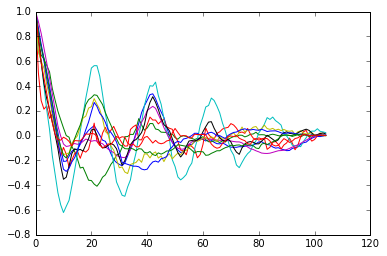

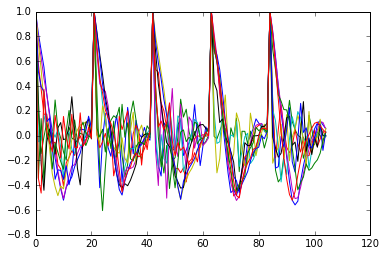

In [6]:
# It doesn't appear the same
plt.plot(a.T)
plt.figure()
plt.plot(auto.T)

In [7]:
def xcorr_experiments(experiments, gene_axis=1):
    return np.array([cc_experiment(experiment.values.T) if gene_axis==1 else cc_experiment(experiment.values)
            for experiment in experiments])

def cc_experiment(x):
    """
    For one experiment. 
    x should be n rows (genes) by m columns (timepoints)
    """
    ccf_array = np.zeros((x.shape[0], x.shape[0], x.shape[1]))
    for ii, static in enumerate(x):
        for jj, moving in enumerate(x):
            if ii==jj:
                unbiased=True
            else:
                unbiased=False
            ccf_array[ii][jj] = ccf(static, moving, unbiased=unbiased)
    return ccf_array



xcorr_list = xcorr_experiments(experiments)

In [8]:
def calc_stationarity(xcorr_list, corr_len=10, x_axis=None):
    if x_axis is None:
        x_axis=np.array(range(corr_len))
    x_axis = x_axis[:corr_len]
    slope_list = []
    pval_list = []
    for xcorr_array in xcorr_list:        
        slopes=[]
        pvals=[]
        ac_tracks = np.diagonal(xcorr_array).T
        for track in ac_tracks:
            line = stats.linregress(x_axis, track[:corr_len])
            slopes.append(line.slope)
            pvals.append(line.pvalue)
        slope_list.append(slopes)
        pval_list.append(pvals)
    pval_array = np.array(pval_list).T*len(ac_tracks)
    return np.array(slope_list).T, pval_array

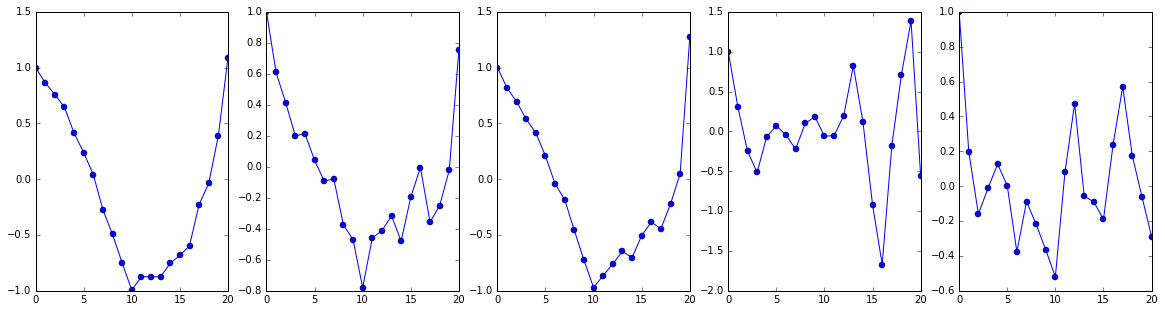

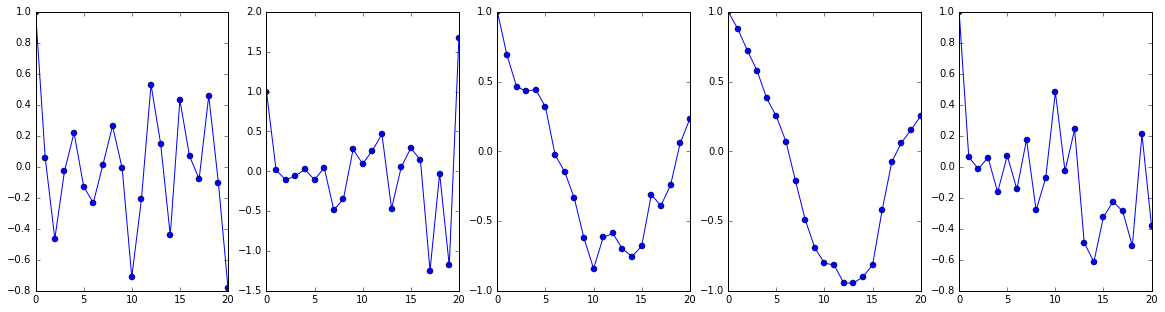

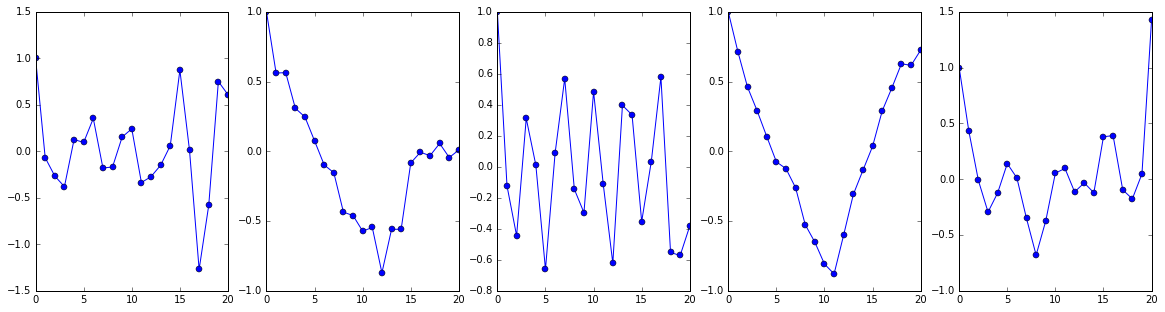

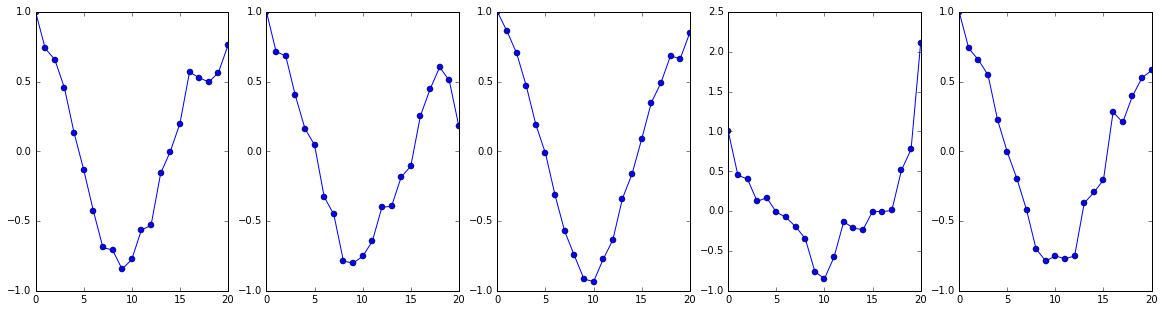

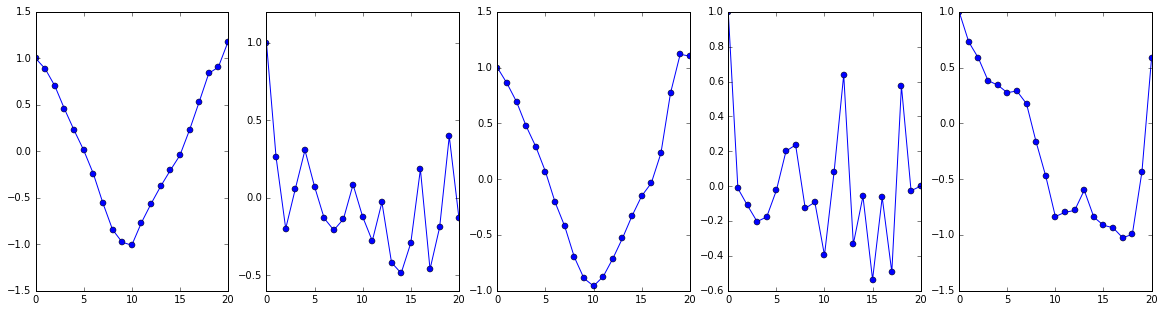

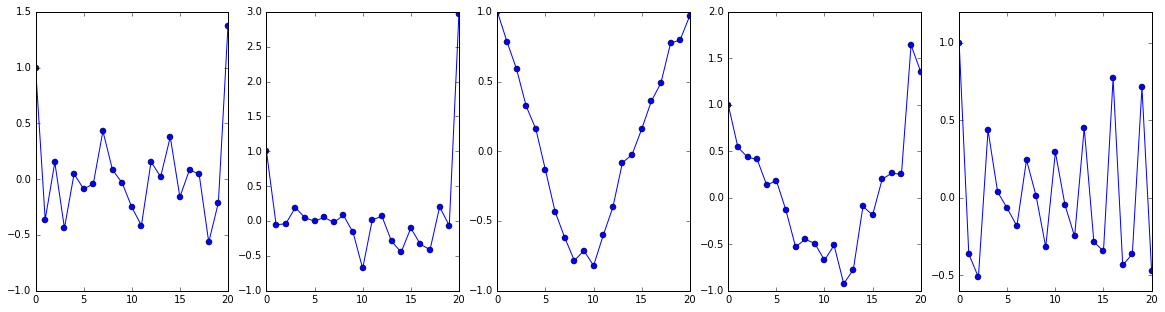

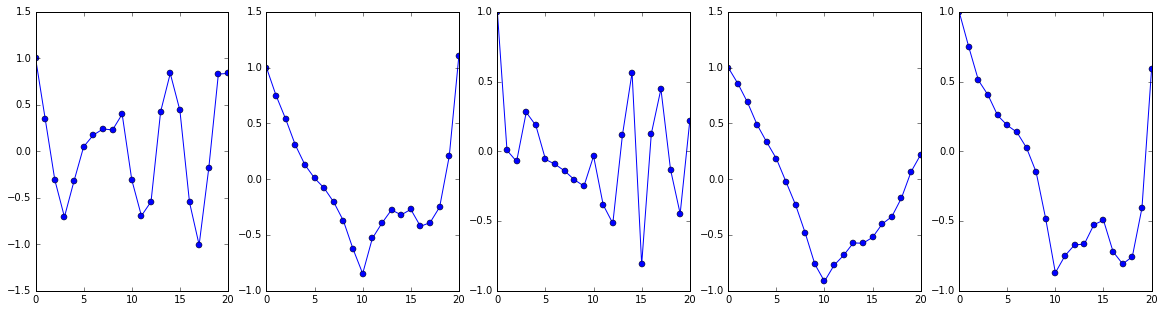

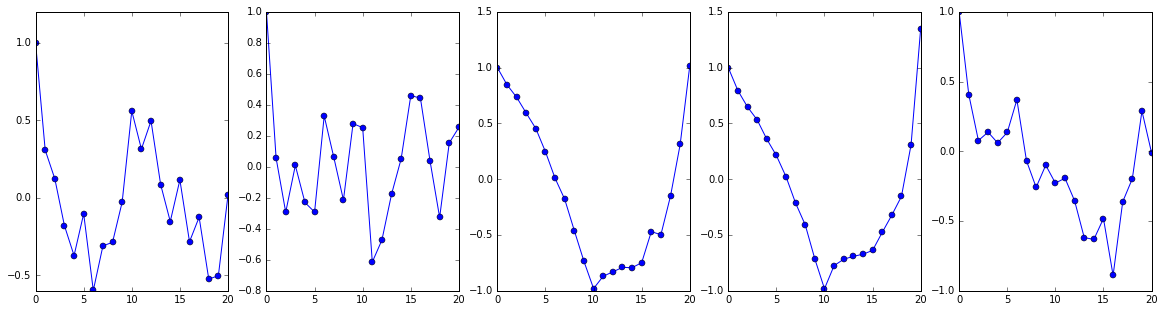

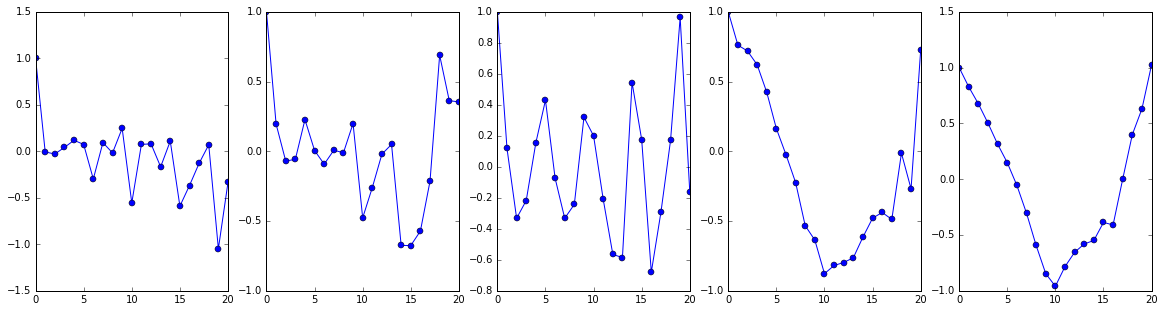

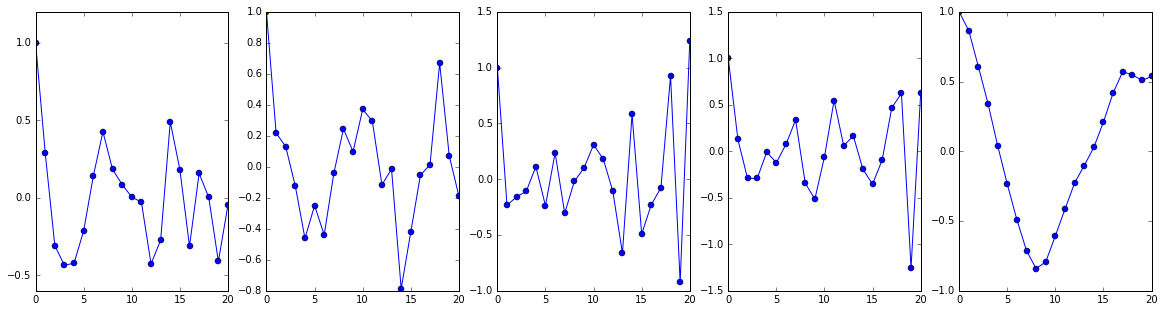

In [9]:

s, p = calc_stationarity(xcorr_list, corr_len=10, x_axis=df.Time)
true_perturbs = pd.read_csv(file_path.replace('timeseries.tsv', 'timeseries_perturbations.tsv'), sep="\t")
for idx in range(len(gene_list)):
    f = plt.figure(figsize=(20,5))
    for ii, ee in enumerate(xcorr_list):
        ax = f.add_subplot(1, 5, ii+1)
        ax.plot(ee[idx,idx], 'o-')

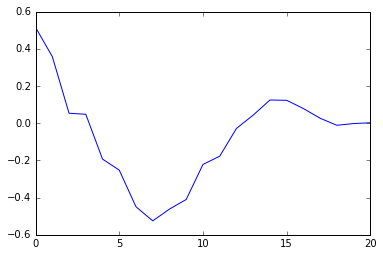

In [10]:
plt.plot(xcorr_list[1,2,3])

In [11]:
current_gold_standard = file_path.replace("timeseries.tsv","goldstandard.tsv")
evaluator = Evaluator(current_gold_standard, '\t')
true_edges = evaluator.gs_flat.tolist()

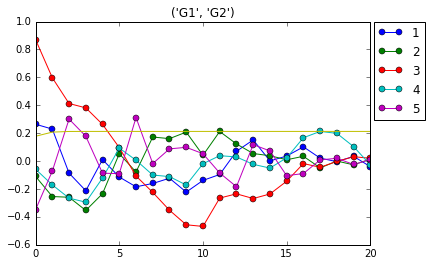

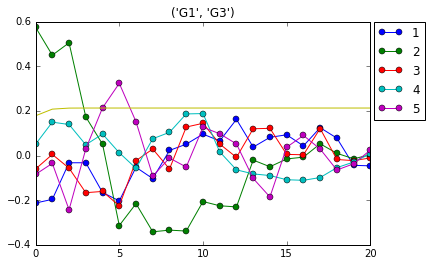

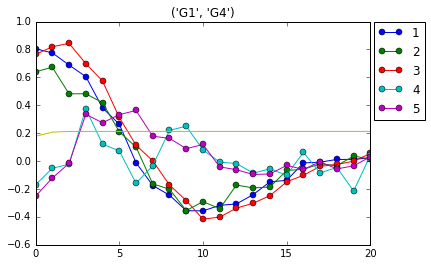

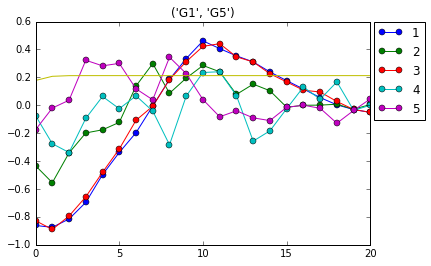

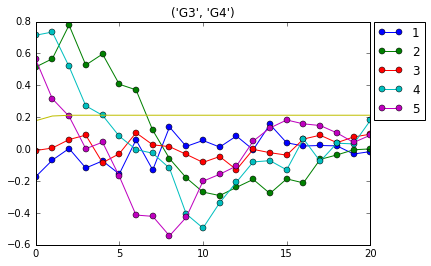

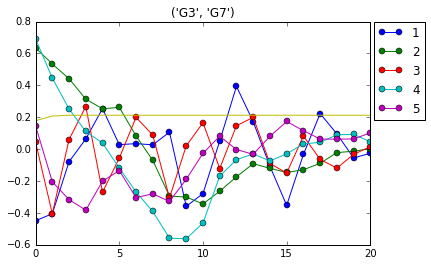

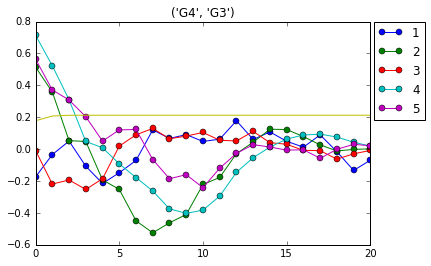

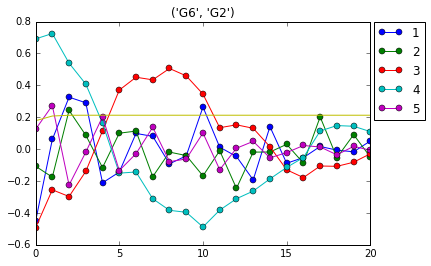

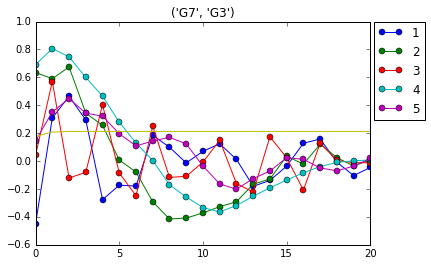

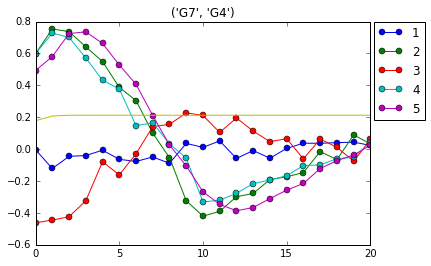

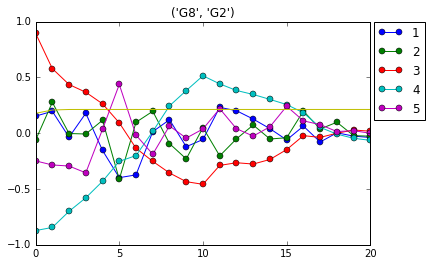

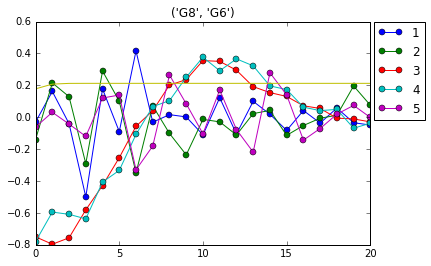

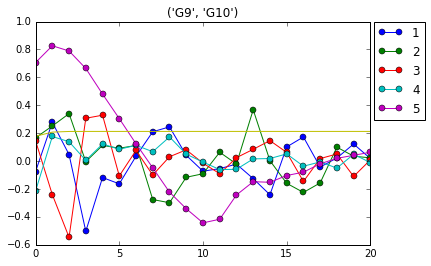

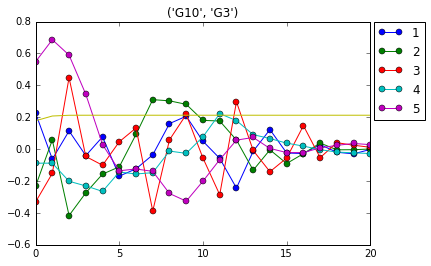

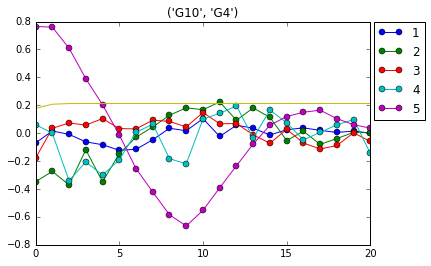

In [12]:

for edge in true_edges:
    p_idx = gene_list.index(edge[0])
    c_idx = gene_list.index(edge[1])
    forward = xcorr_list[:, p_idx, c_idx].T
    reverse = xcorr_list[:, c_idx, p_idx].T
    diff = (forward-reverse)
    diff = diff/np.max(np.abs(diff))/np.array(range(1,len(diff)+1))[:, None]
    plt.figure()
#     plt.plot(np.mean(forward, axis=1), 'o-')
    plt.plot(reverse, 'o-')
    plt.plot((stats.norm.cdf(np.array(range(1,len(diff)+1)))-0.05/2)/np.sqrt(len(diff)))
    plt.legend([1,2,3,4,5], bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.title(edge)

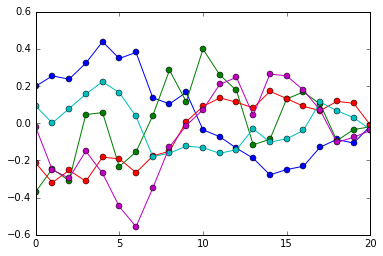

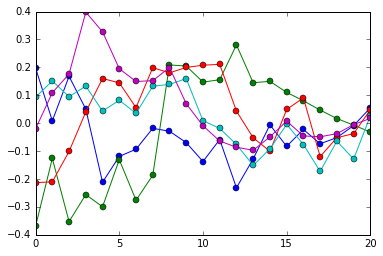

In [23]:
"""
A false edge that shouldn't show influence is G1 and G9
They are distant, and share no connections. Experiments 1-3 perturb G1 but not G9, while experiments 4-5 perturb G9,
but not G1
"""
p_idx = gene_list.index('G1')
c_idx = gene_list.index('G9')
forward = xcorr_list[:, p_idx, c_idx].T
reverse = xcorr_list[:, c_idx, p_idx].T
plt.plot(forward, 'o-')
plt.figure()
plt.plot(reverse, 'o-')